<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Copy_of_Untitled272.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

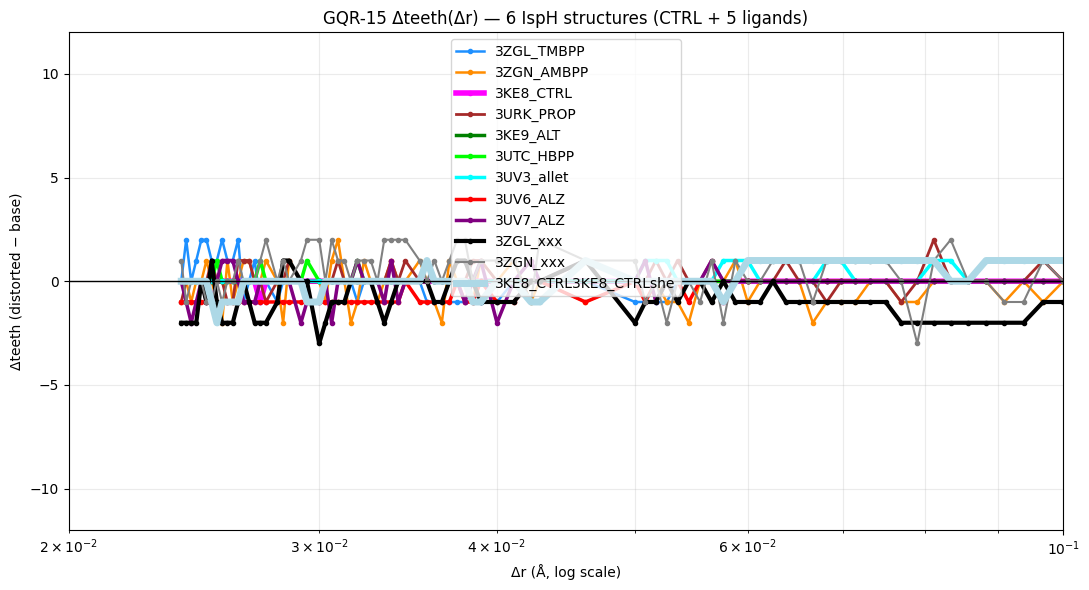

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Directory containing your comb NPZs
LAP_DIR = Path("/content/")

# All six structures
paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":  LAP_DIR / "3UV7_alt_comb_sto3g.npz",
    "3ZGL_xxx":  LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",
    "3ZGN_xxx":  LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",
    "3KE8_CTRL3KE8_CTRLshe":  LAP_DIR / "3KE8_HMBPP_shear_sto3g.npz",

}

# Same NBINS_LIST and parameters as earlier STO-3G runs
BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

def count_traps(mask: np.ndarray) -> int:
    """Count contiguous runs of True in a boolean mask."""
    n = len(mask)
    i = 0
    k = 0
    inside = False
    while i < n:
        if mask[i] and not inside:
            k += 1
            inside = True
        elif not mask[i] and inside:
            inside = False
        i += 1
    return k

def dteeth_from_comb_npz(path: Path):
    """Rebuild Δteeth(Δr) from a comb NPZ with kappa_base/mode."""
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(float(kb.min()), float(km.min()))
    kmax = max(float(kb.max()), float(km.max()))

    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)

        mask_b = hb < TRAP_THRESHOLD
        mask_m = hm < TRAP_THRESHOLD

        n_b = count_traps(mask_b)
        n_m = count_traps(mask_m)

        dr = L_EFF / nb
        dr_list.append(dr)
        dt_list.append(n_m - n_b)

    return np.array(dr_list), np.array(dt_list)

# Compute curves for all six
curves = {}
for label, p in paths.items():
    if not p.exists():
        print(f"[WARN] Missing {p}")
        continue
    dr, dt = dteeth_from_comb_npz(p)
    curves[label] = (dr, dt)

# Plot composite, zoom Δr = 0.02–0.10 Å
plt.figure(figsize=(11,6))

colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",   # CTRL
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":  "purple",
    "3ZGL_xxx":  "black",
    "3ZGN_xxx":  "grey", # Added to match paths
    "3KE8_CTRL3KE8_CTRLshe":  "lightblue"   #shearctrl
}
linewidths = {
    "3ZGL_TMBPP": 1.8,
    "3ZGN_AMBPP": 1.8,
    "3KE8_CTRL":  4.0,   # emphasise control
    "3URK_PROP":  2.0,
    "3KE9_ALT":   2.5,
    "3UTC_HBPP":  2.5,
    "3UV3_allet":  2.5,
    "3UV6_ALZ":   2.5,
    "3UV7_ALZ":  2.5,
    "3ZGL_xxx": 3,
    "3ZGN_xxx": 1.5, # Added to match paths
    "3KE8_CTRL3KE8_CTRLshe":  5   #shearctrl
    }

for label, (dr, dt) in curves.items():
    idx = np.argsort(dr)
    dr_sorted = dr[idx]
    dt_sorted = dt[idx]
    # Zoom region 0.02–0.10 Å
    mask = (dr_sorted >= 2e-2) & (dr_sorted <= 1e-1)
    plt.plot(
        dr_sorted[mask],
        dt_sorted[mask],
        "-o",
        ms=3,
        color=colors[label],
        lw=linewidths[label],
        label=label,
    )

plt.axhline(0, color="k", lw=1)
plt.xscale("log")
plt.xlim(2e-2, 1e-1)
plt.ylim(-12, 12)
plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (distorted − base)")
plt.title("GQR-15 Δteeth(Δr) — 6 IspH structures (CTRL + 5 ligands)")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

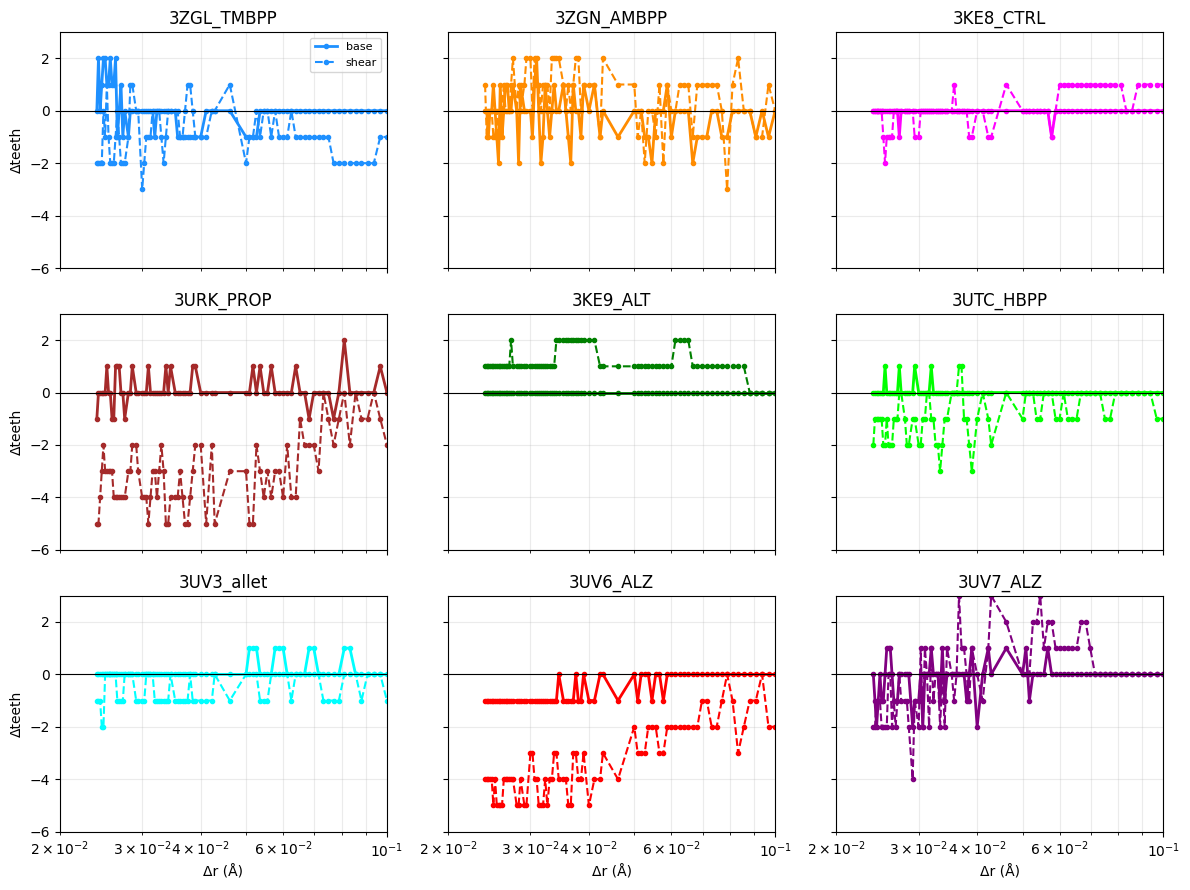

In [ ]:
import numpy as np                                   # 1
import matplotlib.pyplot as plt                      # 2
from pathlib import Path                             # 3

# Directory containing your comb NPZs                 # 4
LAP_DIR = Path("/content/")                          # 5

# Main + shear/alt paths                             # 6
paths = {                                            # 7
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",           # 8
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",           # 9
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",           # 10
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",            # 11
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",            # 12
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",            # 13
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",             # 14
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",             # 15
    "3UV7_ALZ":   LAP_DIR / "3UV7_alt_comb_sto3g.npz",             # 16
    # shear/alt variants                                     # 17
    "3ZGL_shear": LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",         # 18
    "3ZGN_shear": LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",         # 19
    "3KE8_shear": LAP_DIR / "3KE8_HMBPP_shear_sto3g.npz",         # 20
    "3KE9_shear": LAP_DIR / "3KE9_ALT_shear_sto3g.npz",            # 21
    "3URK_shear": LAP_DIR / "3URK_PROP_shear_sto3g.npz",            # 22
    "3UTC_shear": LAP_DIR /  "3UTC_HBPP_shear_sto3g.npz",
    "3UV3_shear": LAP_DIR /  "3UV3_allet_shear_sto3g.npz"  ,
    "3UV6_shear": LAP_DIR /  "3UV6_ALZ_shear_sto3g.npz" ,
    "3UV7_shear": LAP_DIR /  "3UV7_ALZ_shear_sto3g.npz" ,                                                }                                                   # 21
#

# Same NBINS_LIST and parameters as earlier STO-3G runs          # 22
BINS_LIST = [                                       # 23
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,        # 24
    20,21,22,23,24,25,26,27,28,29,                  # 25
    30,31,32,33,34,35,36,37,38,39,                  # 26
    40,41,42,43,44,45,46,47,48,49,                  # 27
    50,51,52,53,54,55,56,57,58,59,                  # 28
    60,65,70,71,73,75,77,78,79,80,                  # 29
    81,82,83,84,85,87,88,89,90,                     # 30
    91,92,93,94,95,96,97,98,99,100,                 # 31
    102,103,105,106,107,109,                        # 32
    110,111,112,113,114,115,116,117,118,119,120,    # 33
    121,122,123,124,125                             # 34
]                                                   # 35

L_EFF = 3.0                                         # 36
TRAP_THRESHOLD = 1e-9                               # 37


def count_traps(mask: np.ndarray) -> int:           # 38
    """Count contiguous runs of True in a boolean mask."""         # 39
    n = len(mask)                                                  # 40
    i = 0                                                          # 41
    k = 0                                                          # 42
    inside = False                                                 # 43
    while i < n:                                                   # 44
        if mask[i] and not inside:                                 # 45
            k += 1                                                 # 46
            inside = True                                          # 47
        elif not mask[i] and inside:                               # 48
            inside = False                                         # 49
        i += 1                                                     # 50
    return k                                                       # 51


def dteeth_from_comb_npz(path: Path):            # 52
    """Rebuild Δteeth(Δr) from a comb NPZ with kappa_base/mode.""" # 53
    d = np.load(path, allow_pickle=True)                          # 54
    kb = d["kappa_base"].ravel()                                  # 55
    km = d["kappa_mode"].ravel()                                  # 56
    kmin = min(float(kb.min()), float(km.min()))                   # 57
    kmax = max(float(kb.max()), float(km.max()))                   # 58

    dr_list = []                                                  # 59
    dt_list = []                                                  # 60
    for nb in BINS_LIST:                                          # 61
        edges = np.linspace(kmin, kmax, nb+1)                     # 62
        hb,_ = np.histogram(kb, bins=edges, density=True)         # 63
        hm,_ = np.histogram(km, bins=edges, density=True)         # 64

        mask_b = hb < TRAP_THRESHOLD                              # 65
        mask_m = hm < TRAP_THRESHOLD                              # 66

        n_b = count_traps(mask_b)                                 # 67
        n_m = count_traps(mask_m)                                 # 68

        dr = L_EFF / nb                                           # 69
        dr_list.append(dr)                                        # 70
        dt_list.append(n_m - n_b)                                 # 71

    return np.array(dr_list), np.array(dt_list)                   # 72


# Order of the 9 main structures in the 3×3 grid                   # 73
main_labels = [                                                    # 74
    "3ZGL_TMBPP", "3ZGN_AMBPP", "3KE8_CTRL",                       # 75
    "3URK_PROP", "3KE9_ALT",  "3UTC_HBPP",                         # 76
    "3UV3_allet", "3UV6_ALZ", "3UV7_ALZ",                          # 77
]                                                                  # 78

# Map each main structure to its shear/alt partner (if any)         # 79
shear_partner = {                                                  # 80
    "3ZGL_TMBPP": "3ZGL_shear",                                    # 81
    "3ZGN_AMBPP": "3ZGN_shear",                                    # 82
    "3KE8_CTRL":  "3KE8_shear",                                    # 83
    "3URK_PROP":  "3URK_shear",                                            # 84
    "3KE9_ALT":   "3KE9_shear",                                            # 85
    "3UTC_HBPP":  "3UTC_shear",                                          # 86
    "3UV3_allet": "3UV3_shear",                                          # 87
    "3UV6_ALZ":   "3UV6_shear",                                           # 88
    "3UV7_ALZ":   "3UV7_shear",                                        # 89
}                                                                  # 90

# Colours for each main curve (reusing your palette)                # 91
colors = {                                                         # 92
    "3ZGL_TMBPP": "dodgerblue",                                    # 93
    "3ZGN_AMBPP": "darkorange",                                    # 94
    "3KE8_CTRL":  "magenta",                                       # 95
    "3URK_PROP":  "brown",                                         # 96
    "3KE9_ALT":   "green",                                         # 97
    "3UTC_HBPP":  "lime",                                          # 98
    "3UV3_allet": "cyan",                                          # 99
    "3UV6_ALZ":   "red",                                           # 100
    "3UV7_ALZ":   "purple"
                                                                  # 101
}                                                                  # 102


# Precompute curves for everything we have                          # 103
curves = {}                                                        # 104
for label, p in paths.items():                                     # 105
    if not p.exists():                                             # 106
        print(f"[WARN] Missing {p}")                               # 107
        continue                                                   # 108
    dr, dt = dteeth_from_comb_npz(p)                               # 109
    curves[label] = (dr, dt)                                       # 110


# 3×3 grid of small-multiple “teeth” plots                          # 111
fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)  # 112

for idx, main_label in enumerate(main_labels):                     # 113
    row = idx // 3                                                 # 114
    col = idx % 3                                                  # 115
    ax = axes[row, col]                                            # 116

    if main_label not in curves:                                   # 117
        ax.set_title(main_label + " (missing)")                    # 118
        ax.axis("off")                                             # 119
        continue                                                   # 120

    color = colors.get(main_label, "black")                        # 121
    dr_main, dt_main = curves[main_label]                          # 122

    # sort & zoom                                                   # 123
    idx_sort = np.argsort(dr_main)                                 # 124
    dr_s = dr_main[idx_sort]                                       # 125
    dt_s = dt_main[idx_sort]                                       # 126
    mask = (dr_s >= 2e-2) & (dr_s <= 1e-1)                         # 127

    ax.plot(dr_s[mask], dt_s[mask], "-o",
            ms=3, color=color, lw=2.0, label="base")               # 128

    # shear / alt partner as dashed, same colour                    # 129
    sp = shear_partner.get(main_label)                             # 130
    if sp is not None and sp in curves:                            # 131
        dr_sh, dt_sh = curves[sp]                                  # 132
        idx_s2 = np.argsort(dr_sh)                                 # 133
        dr_sh_s = dr_sh[idx_s2]                                    # 134
        dt_sh_s = dt_sh[idx_s2]                                    # 135
        mask2 = (dr_sh_s >= 2e-2) & (dr_sh_s <= 1e-1)              # 136
        ax.plot(dr_sh_s[mask2], dt_sh_s[mask2], "--o",
                ms=3, color=color, lw=1.5, label="shear")          # 137

    ax.axhline(0, color="k", lw=0.8)                               # 138
    ax.set_xscale("log")                                           # 139
    ax.set_xlim(2e-2, 1e-1)                                        # 140
    ax.set_ylim(-6, 3)                                           # 141
    ax.grid(True, which="both", alpha=0.25)                        # 142
    ax.set_title(main_label)                                       # 143
    if row == 2:                                                   # 144
        ax.set_xlabel("Δr (Å)")                                    # 145
    if col == 0:                                                   # 146
        ax.set_ylabel("Δteeth")                                    # 147

# Single legend for one of the axes (top-left)                      # 148
axes[0, 0].legend(loc="best", fontsize=8)                          # 149

plt.tight_layout()                                                 # 150
plt.show()                                                         # 151

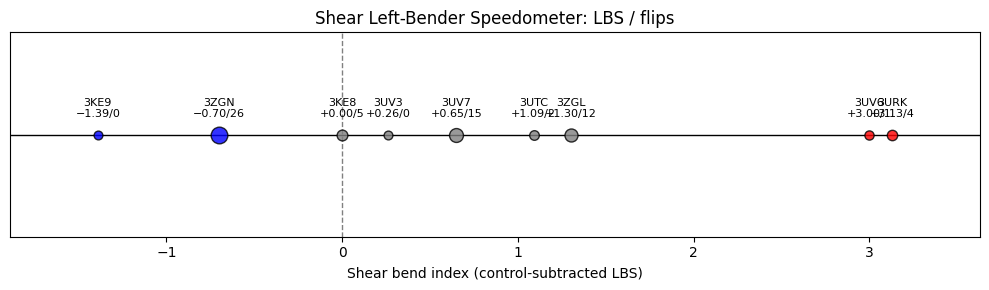

In [ ]:
import matplotlib.pyplot as plt

# Shear metrics (control-subtracted LBS + zero-propagated flips)
# From our last computation:
shear_data = {
    "3URK":   ( 3.13,  4),
    "3UV6":   ( 3.00,  1),
    "3ZGL":   ( 1.30, 12),
    "3UTC":   ( 1.09,  2),
    "3UV7":   ( 0.65, 15),
    "3UV3":   ( 0.26,  0),
    "3KE8":   ( 0.00,  5),   # control
    "3ZGN":   (-0.70, 26),
    "3KE9":   (-1.39,  0),
}

labels  = list(shear_data.keys())
lbs     = [shear_data[k][0] for k in labels]
flips   = [shear_data[k][1] for k in labels]

fig, ax = plt.subplots(figsize=(10, 3))

# Draw a horizontal "speedometer" axis
xmin = min(lbs) - 0.5
xmax = max(lbs) + 0.5
ax.axhline(0, color="black", lw=1)
ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, 1)

# Vertical line at 0 (control)
ax.axvline(0, color="grey", lw=1, ls="--")

# Plot each structure as a dot on the speedo
for i, (lab, x, nf) in enumerate(zip(labels, lbs, flips)):
    # Colour: red for strong left-bender, blue-ish for right/flat, grey mid
    if x > 2.0:
        color = "red"
    elif x < -0.2:
        color = "blue"
    else:
        color = "grey"

    # Marker size scaled with flip count
    size = 40 + 4 * nf

    ax.scatter(x, 0, s=size, c=color, alpha=0.8, edgecolor="k", zorder=3)

    # Text label just above the point: LBS/flips e.g. +3.1/4
    sign = "+" if x >= 0 else "−"
    txt = f"{sign}{abs(x):.2f}/{nf}"
    ax.text(x, 0.15, f"{lab}\n{txt}",
            ha="center", va="bottom", fontsize=8, rotation=0)

ax.set_yticks([])
ax.set_xlabel("Shear bend index (control-subtracted LBS)")
ax.set_title("Shear Left-Bender Speedometer: LBS / flips")

plt.tight_layout()
plt.show()

/tmp/ipython-input-2511920103.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


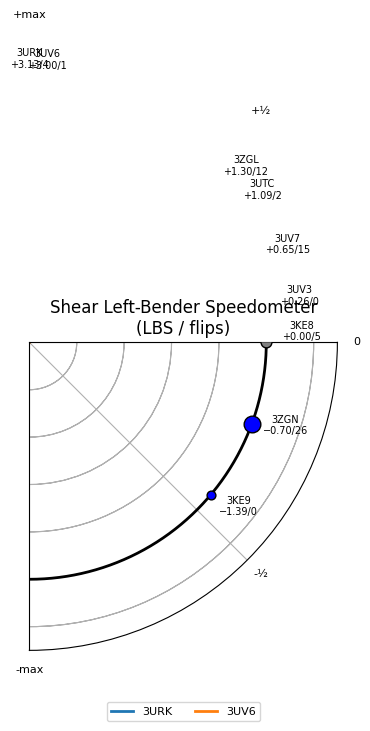

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- SHEAR METRICS (control-subtracted) ---
shear_data = {
    "3URK":   ( 3.13,  4),
    "3UV6":   ( 3.00,  1),
    "3ZGL":   ( 1.30, 12),
    "3UTC":   ( 1.09,  2),
    "3UV7":   ( 0.65, 15),
    "3UV3":   ( 0.26,  0),
    "3KE8":   ( 0.00,  5),   # control
    "3ZGN":   (-0.70, 26),
    "3KE9":   (-1.39,  0),
}

labels = list(shear_data.keys())
lbs    = np.array([shear_data[k][0] for k in labels])
flips  = np.array([shear_data[k][1] for k in labels])

# map LBS range to angles from -90° (left) to +90° (right)
max_abs = max(abs(lbs.min()), abs(lbs.max()))
angles = (lbs / max_abs) * (np.pi/2)   # -pi/2 .. +pi/2

# gauge radius
R = 1.0

fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection": "polar"})

# draw semi-circle background
theta_bg = np.linspace(-np.pi/2, np.pi/2, 200)
ax.plot(theta_bg, np.full_like(theta_bg, R), color="black", lw=2)

# colour by strength
def color_for_lbs(x):
    if x > 2.0:
        return "red"
    elif x < -0.2:
        return "blue"
    else:
        return "grey"

# plot each structure as a marker on the rim
for ang, lab, x, nf in zip(angles, labels, lbs, flips):
    col = color_for_lbs(x)
    size = 40 + 4*nf   # bigger dot = more flips

    ax.scatter(ang, R, s=size, c=col, edgecolor="k", zorder=3)

    sign = "+" if x >= 0 else "−"
    txt  = f"{sign}{abs(x):.2f}/{nf}"
    ax.text(ang, R+0.15, f"{lab}\n{txt}",
            ha="center", va="bottom", fontsize=7)

# needle: show the two extreme left-benders as example
for key in ["3URK", "3UV6"]:
    x, nf = shear_data[key]
    ang = (x / max_abs) * (np.pi/2)
    ax.plot([0, ang], [0, R*0.9], lw=2, label=key)

# format gauge
ax.set_ylim(0, R+0.3)
ax.set_yticklabels([])
ax.set_xticks(np.linspace(-np.pi/2, np.pi/2, 5))
ax.set_xticklabels(["-max", "-½", "0", "+½", "+max"], fontsize=8)

ax.set_title("Shear Left-Bender Speedometer\n(LBS / flips)", fontsize=12)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8)

plt.tight_layout()
plt.show()

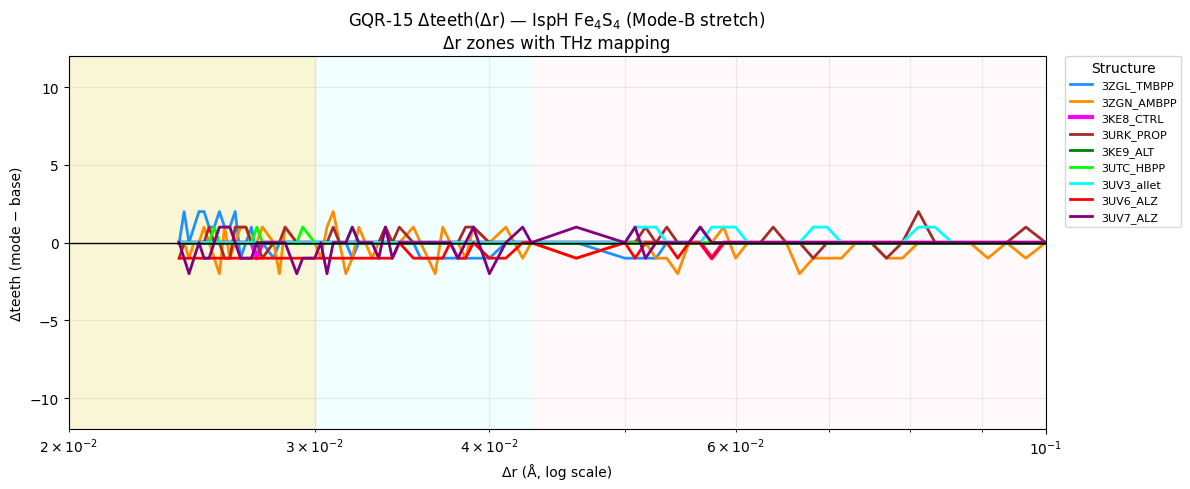

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# CONFIG
# ---------------------------
LAP_DIR = Path("/content/")

# comb (Mode-B stretch) NPZs only
stretch_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_alt_comb_sto3g.npz",
}

# same NBINS_LIST / params as before
BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

# colour mapping as in 3×3 grid
colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":   "purple",
}

# optional: line widths
linewidths = {lab: 2.0 for lab in stretch_paths}
linewidths["3KE8_CTRL"] = 3.0   # emphasise control if you like

# Δr zones (tweak boundaries if you want to match earlier THz mapping)
zone1 = (2.0e-2, 3.0e-2)   # left band (e.g. high THz)
zone2 = (3.0e-2, 4.3e-2)   # middle band
zone3 = (4.3e-2, 1.0e-1)   # right band (lower THz)


def count_traps(mask: np.ndarray) -> int:
    inside = False
    k = 0
    for m in mask:
        if m and not inside:
            k += 1
            inside = True
        elif not m and inside:
            inside = False
    return k


def dteeth_from_npz(path: Path):
    """Compute Δteeth(Δr) from NPZ with kappa_base / kappa_mode."""
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(float(kb.min()), float(km.min()))
    kmax = max(float(kb.max()), float(km.max()))

    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)

        mask_b = hb < TRAP_THRESHOLD
        mask_m = hm < TRAP_THRESHOLD

        n_b = count_traps(mask_b)
        n_m = count_traps(mask_m)

        dr = L_EFF / nb
        dr_list.append(dr)
        dt_list.append(n_m - n_b)

    return np.array(dr_list), np.array(dt_list)


# ---------------------------
# PLOT
# ---------------------------
fig, ax = plt.subplots(figsize=(12, 5))

# background Δr zones
ax.axvspan(zone1[0], zone1[1], color="khaki", alpha=0.35, zorder=0)
ax.axvspan(zone2[0], zone2[1], color="lightcyan", alpha=0.4, zorder=0)
ax.axvspan(zone3[0], zone3[1], color="lavenderblush", alpha=0.4, zorder=0)

# curves
for label, path in stretch_paths.items():
    if not path.exists():
        print(f"[WARN] missing {path}")
        continue

    dr, dt = dteeth_from_npz(path)
    idx = np.argsort(dr)
    dr_sorted = dr[idx]
    dt_sorted = dt[idx]

    # zoom Δr = 0.02–0.10 Å
    mask = (dr_sorted >= 2e-2) & (dr_sorted <= 1e-1)
    drz = dr_sorted[mask]
    dtz = dt_sorted[mask]

    ax.plot(
        drz,
        dtz,
        "-",
        lw=linewidths.get(label, 2.0),
        color=colors.get(label, "black"),
        label=label,
    )

ax.axhline(0, color="k", lw=1)
ax.set_xscale("log")
ax.set_xlim(2e-2, 1e-1)
ax.set_ylim(-12, 12)
ax.set_xlabel("Δr (Å, log scale)")
ax.set_ylabel("Δteeth (mode − base)")
ax.set_title("GQR-15 Δteeth(Δr) — IspH Fe$_4$S$_4$ (Mode-B stretch)\nΔr zones with THz mapping")

ax.grid(True, which="both", alpha=0.25)

# legend outside the plot (right-hand side)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
          borderaxespad=0, fontsize=8, title="Structure")

plt.tight_layout()
plt.show()

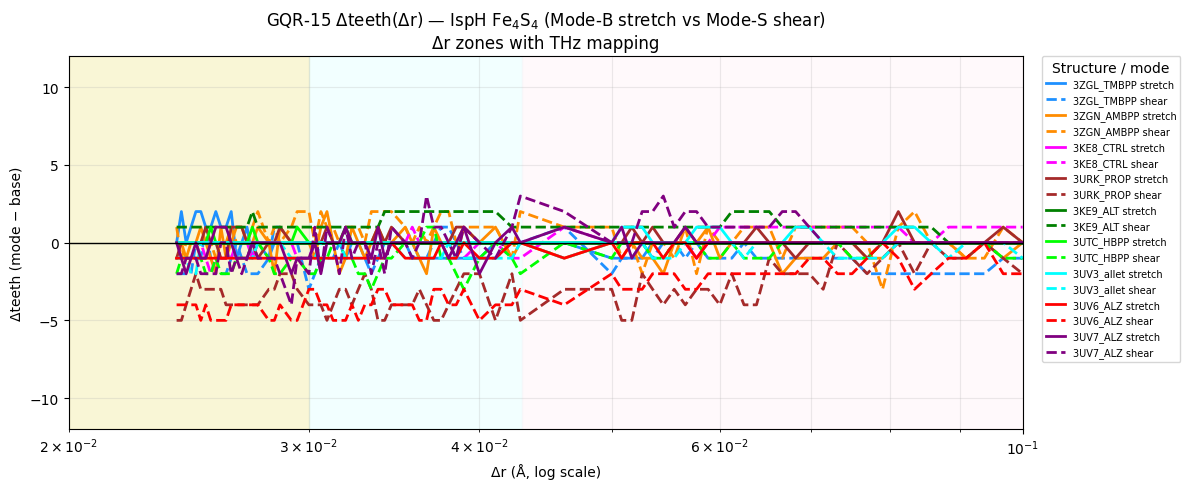

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

LAP_DIR = Path("/content/")

# --- comb (Mode-B stretch) NPZs ---
stretch_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_alt_comb_sto3g.npz",
}

# --- shear (Mode-S) NPZs ---
shear_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_shear_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK_PROP_shear_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9_ALT_shear_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC_HBPP_shear_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_allet_shear_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_ALZ_shear_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_ALZ_shear_sto3g.npz",
}

BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

# Same colours as 3×3 grid
colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":   "purple",
}

def count_traps(mask: np.ndarray) -> int:
    inside = False
    k = 0
    for m in mask:
        if m and not inside:
            k += 1
            inside = True
        elif not m and inside:
            inside = False
    return k

def dteeth_from_npz(path: Path):
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(float(kb.min()), float(km.min()))
    kmax = max(float(kb.max()), float(km.max()))
    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)
        mask_b = hb < TRAP_THRESHOLD
        mask_m = hm < TRAP_THRESHOLD
        n_b = count_traps(mask_b)
        n_m = count_traps(mask_m)
        dr_list.append(L_EFF / nb)
        dt_list.append(n_m - n_b)
    return np.array(dr_list), np.array(dt_list)

# Δr zones (match your earlier THz mapping)
zone1 = (2.0e-2, 3.0e-2)
zone2 = (3.0e-2, 4.3e-2)
zone3 = (4.3e-2, 1.0e-1)

fig, ax = plt.subplots(figsize=(12,5))

# background bands
ax.axvspan(zone1[0], zone1[1], color="khaki",        alpha=0.35, zorder=0)
ax.axvspan(zone2[0], zone2[1], color="lightcyan",    alpha=0.40, zorder=0)
ax.axvspan(zone3[0], zone3[1], color="lavenderblush",alpha=0.40, zorder=0)

for label in stretch_paths:
    stretch_file = stretch_paths[label]
    shear_file   = shear_paths.get(label)

    if not stretch_file.exists():
        print(f"[WARN] missing stretch file for {label}: {stretch_file}")
        continue
    if shear_file is None or not shear_file.exists():
        print(f"[WARN] missing shear file for {label}: {shear_file}")
        continue

    # compute Δteeth for stretch
    dr_st, dt_st = dteeth_from_npz(stretch_file)
    # compute Δteeth for shear
    dr_sh, dt_sh = dteeth_from_npz(shear_file)

    # sort (assume same Δr grid)
    idx = np.argsort(dr_st)
    dr = dr_st[idx]
    dt_st = dt_st[idx]
    dt_sh = dt_sh[idx]

    # zoom region
    mask = (dr >= 2e-2) & (dr <= 1e-1)
    drz = dr[mask]
    stz = dt_st[mask]
    shz = dt_sh[mask]

    c = colors[label]

    # stretch = solid
    ax.plot(drz, stz, "-",  lw=2.0, color=c, label=f"{label} stretch")

    # shear = dashed
    ax.plot(drz, shz, "--", lw=2.0, color=c, label=f"{label} shear")

ax.axhline(0, color="k", lw=1)
ax.set_xscale("log")
ax.set_xlim(2e-2, 1e-1)
ax.set_ylim(-12, 12)
ax.set_xlabel("Δr (Å, log scale)")
ax.set_ylabel("Δteeth (mode − base)")
ax.set_title("GQR-15 Δteeth(Δr) — IspH Fe$_4$S$_4$ (Mode-B stretch vs Mode-S shear)\nΔr zones with THz mapping")

ax.grid(True, which="both", alpha=0.25)

# Legend outside on the right
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
          borderaxespad=0, fontsize=7, title="Structure / mode")

plt.tight_layout()
plt.show()

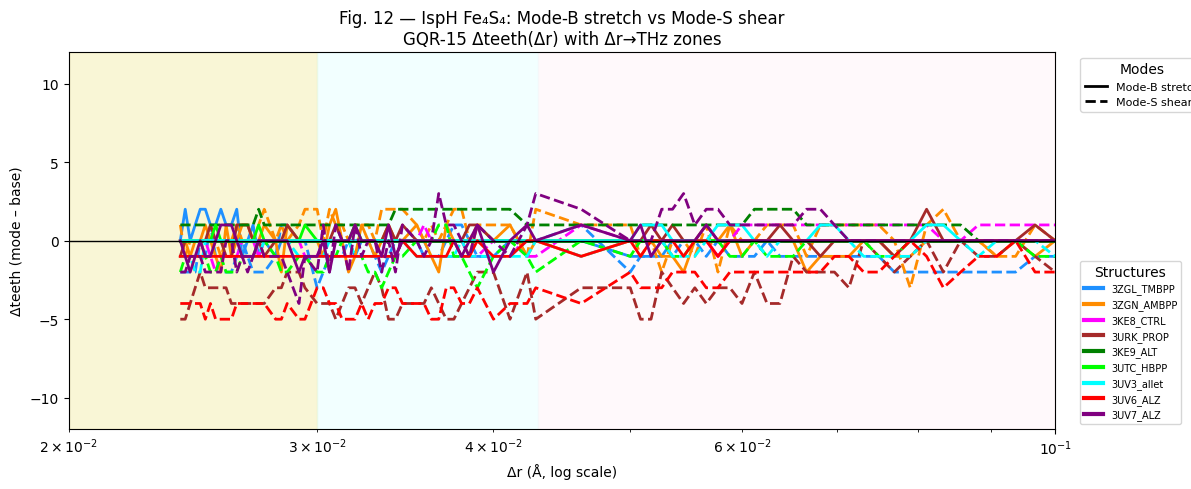

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.lines as mlines

LAP_DIR = Path("/content/")

stretch_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_alt_comb_sto3g.npz"
}

shear_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_shear_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK_PROP_shear_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9_ALT_shear_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC_HBPP_shear_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_allet_shear_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_ALZ_shear_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_ALZ_shear_sto3g.npz"
}

BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]

L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":   "purple"
}

def count_traps(mask):
    inside = False
    k = 0
    for m in mask:
        if m and not inside:
            k += 1
            inside = True
        elif not m and inside:
            inside = False
    return k

def dteeth_from_npz(path):
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(kb.min(), km.min())
    kmax = max(kb.max(), km.max())
    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)
        n_b = count_traps(hb < TRAP_THRESHOLD)
        n_m = count_traps(hm < TRAP_THRESHOLD)
        dr_list.append(L_EFF / nb)
        dt_list.append(n_m - n_b)
    return np.array(dr_list), np.array(dt_list)

zone1 = (2e-2, 3e-2)
zone2 = (3e-2, 4.3e-2)
zone3 = (4.3e-2, 1e-1)

fig, ax = plt.subplots(figsize=(12,5))

ax.axvspan(zone1[0], zone1[1], color="khaki", alpha=0.35)
ax.axvspan(zone2[0], zone2[1], color="lightcyan", alpha=0.4)
ax.axvspan(zone3[0], zone3[1], color="lavenderblush", alpha=0.4)

for label in stretch_paths:
    st_path = stretch_paths[label]
    sh_path = shear_paths[label]

    dr_st, dt_st = dteeth_from_npz(st_path)
    dr_sh, dt_sh = dteeth_from_npz(sh_path)

    idx = np.argsort(dr_st)
    dr = dr_st[idx]
    dt_st = dt_st[idx]
    dt_sh = dt_sh[idx]

    mask = (dr >= 2e-2) & (dr <= 1e-1)
    drz = dr[mask]
    stz = dt_st[mask]
    shz = dt_sh[mask]

    c = colors[label]

    ax.plot(drz, stz, "-",  lw=2, color=c)
    ax.plot(drz, shz, "--", lw=2, color=c)

ax.axhline(0, color="black", lw=1)
ax.set_xscale("log")
ax.set_xlim(2e-2, 1e-1)
ax.set_ylim(-12, 12)
ax.set_xlabel("Δr (Å, log scale)")
ax.set_ylabel("Δteeth (mode – base)")
ax.set_title("Fig. 12 — IspH Fe₄S₄: Mode-B stretch vs Mode-S shear\nGQR-15 Δteeth(Δr) with Δr→THz zones")

stretch_handle = mlines.Line2D([], [], color="black", lw=2, linestyle="-", label="Mode-B stretch")
shear_handle   = mlines.Line2D([], [], color="black", lw=2, linestyle="--", label="Mode-S shear")
mode_legend = ax.legend(handles=[stretch_handle, shear_handle],
                        loc="upper left", bbox_to_anchor=(1.02, 1.0),
                        fontsize=8, title="Modes")

structure_handles = [
    mlines.Line2D([], [], color=colors[label], lw=3, label=label)
    for label in stretch_paths
]
struct_legend = ax.legend(handles=structure_handles,
                          loc="lower left", bbox_to_anchor=(1.02, 0),
                          fontsize=7, title="Structures")

ax.add_artist(mode_legend)

plt.tight_layout()
plt.show()

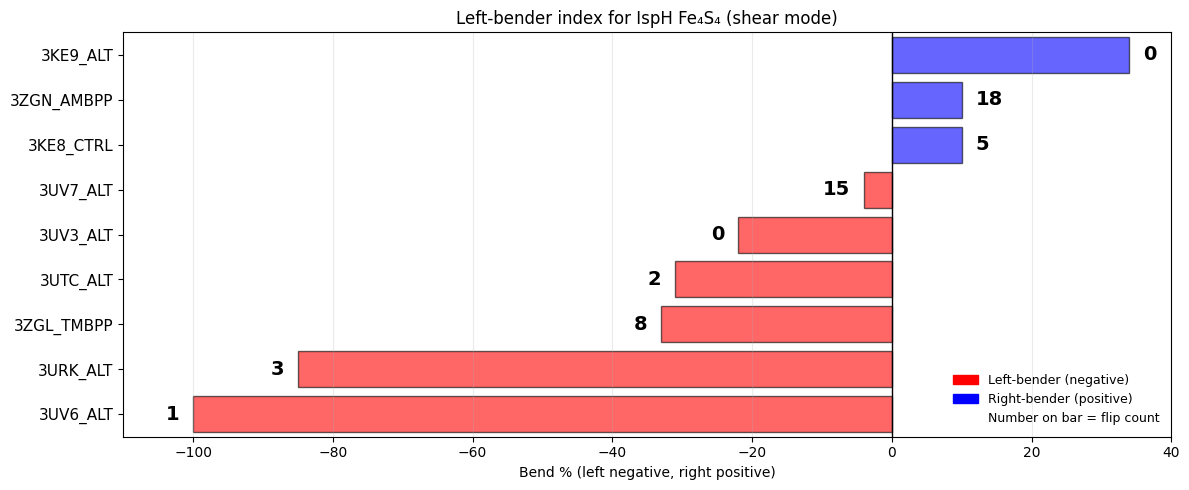

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

structures = [
    "3UV6_ALT",
    "3URK_ALT",
    "3ZGL_TMBPP",
    "3UTC_ALT",
    "3UV3_ALT",
    "3UV7_ALT",
    "3KE8_CTRL",
    "3ZGN_AMBPP",
    "3KE9_ALT",
]

bend = np.array([-100.0, -85.0, -33.0, -31.0, -22.0, -4.0, 10.0, 10.0, 34.0])
flips = np.array([1, 3, 8, 2, 0, 15, 5, 18, 0])

colors = []
for b in bend:
    if b < 0:
        colors.append("red")
    elif b > 0:
        colors.append("blue")
    else:
        colors.append("grey")

y_pos = np.arange(len(structures))

fig, ax = plt.subplots(figsize=(12, 5))

bars = ax.barh(y_pos, bend, color=colors, edgecolor="black", alpha=0.6)

for i, (b, f) in enumerate(zip(bend, flips)):
    x_text = b + (-2 if b < 0 else 2)
    ha = "right" if b < 0 else "left"
    ax.text(x_text, y_pos[i], f"{int(f)}",
            va="center", ha=ha, fontsize=14, fontweight="bold")

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(structures, fontsize=11)
ax.set_xlabel("Bend % (left negative, right positive)")
ax.set_title("Left-bender index for IspH Fe₄S₄ (shear mode)")

ax.set_xlim(-110, 40)
ax.set_ylim(-0.5, len(structures)-0.5)
ax.grid(axis="x", alpha=0.25)

left_patch  = mpatches.Patch(color="red",  label="Left-bender (negative)")
right_patch = mpatches.Patch(color="blue", label="Right-bender (positive)")
note_patch  = mpatches.Patch(color="none", label="Number on bar = flip count")

ax.legend(handles=[left_patch, right_patch, note_patch],
          loc="lower right", frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

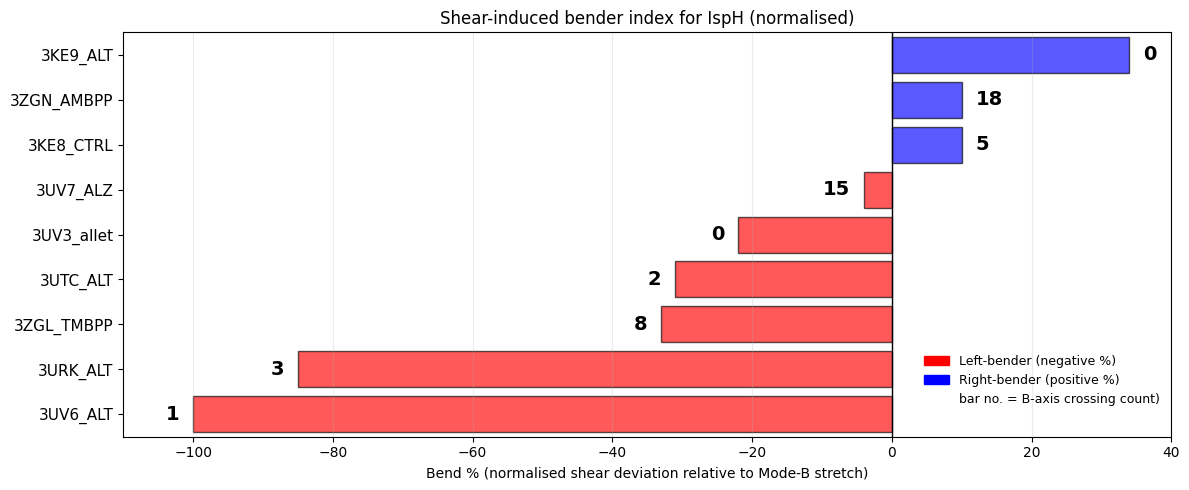

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

structures = [
    "3UV6_ALT",
    "3URK_ALT",
    "3ZGL_TMBPP",
    "3UTC_ALT",
    "3UV3_allet",
    "3UV7_ALZ",
    "3KE8_CTRL",
    "3ZGN_AMBPP",
    "3KE9_ALT",
]

bend = np.array([-100.0, -85.0, -33.0, -31.0, -22.0, -4.0, 10.0, 10.0, 34.0])
flips = np.array([1, 3, 8, 2, 0, 15, 5, 18, 0])

colors = ["red" if b < 0 else "blue" if b > 0 else "grey" for b in bend]

y_pos = np.arange(len(structures))

fig, ax = plt.subplots(figsize=(12,5))

bars = ax.barh(y_pos, bend, color=colors, edgecolor="black", alpha=0.65)

for i, (b, f) in enumerate(zip(bend, flips)):
    x_text = b + (-2 if b < 0 else 2)
    ha = "right" if b < 0 else "left"
    ax.text(x_text, y_pos[i], f"{int(f)}",
            va="center", ha=ha, fontsize=14, fontweight="bold")

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(structures, fontsize=11)
ax.set_xlabel("Bend % (normalised shear deviation relative to Mode-B stretch)")
ax.set_title("Shear-induced bender index for IspH (normalised)")

ax.set_xlim(-110, 40)
ax.set_ylim(-0.5, len(structures)-0.5)
ax.grid(axis="x", alpha=0.25)

left_patch  = mpatches.Patch(color="red",  label="Left-bender (negative %)")
right_patch = mpatches.Patch(color="blue", label="Right-bender (positive %)")
flip_patch  = mpatches.Patch(color="none", label="bar no. = B-axis crossing count)")
norm_patch  = mpatches.Patch(color="none",)

ax.legend(handles=[left_patch, right_patch, flip_patch, norm_patch],
          loc="lower right", frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

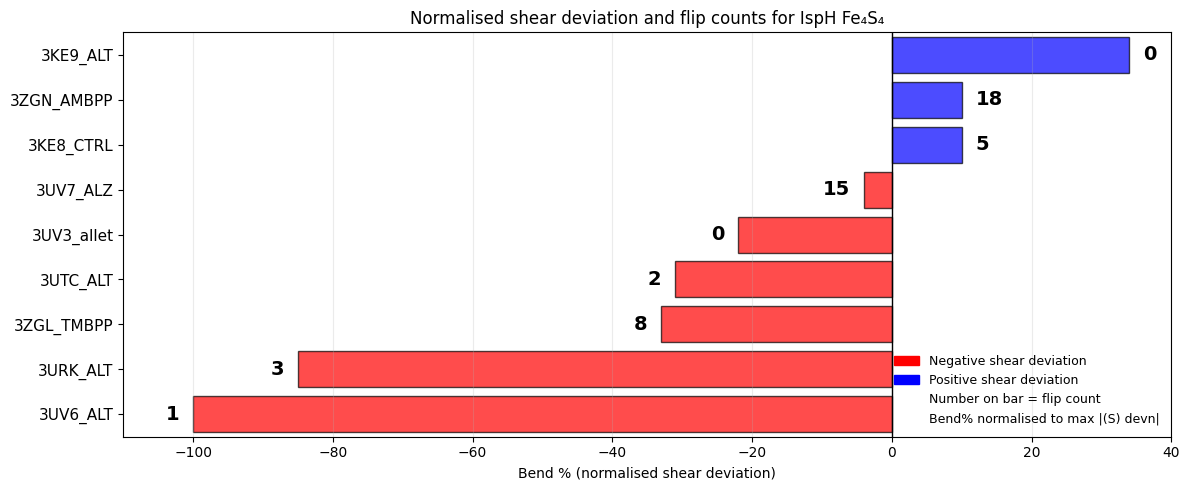

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

structures = [
    "3UV6_ALT",
    "3URK_ALT",
    "3ZGL_TMBPP",
    "3UTC_ALT",
    "3UV3_allet",
    "3UV7_ALZ",
    "3KE8_CTRL",
    "3ZGN_AMBPP",
    "3KE9_ALT",
]

bend = np.array([-100.0, -85.0, -33.0, -31.0, -22.0, -4.0, 10.0, 10.0, 34.0])
flips = np.array([1, 3, 8, 2, 0, 15, 5, 18, 0])

colors = []
for b in bend:
    if b < 0:
        colors.append("red")
    elif b > 0:
        colors.append("blue")
    else:
        colors.append("grey")

y_pos = np.arange(len(structures))

fig, ax = plt.subplots(figsize=(12, 5))

bars = ax.barh(y_pos, bend, color=colors, edgecolor="black", alpha=0.7)

for i, (b, f) in enumerate(zip(bend, flips)):
    x_text = b + (-2 if b < 0 else 2)
    ha = "right" if b < 0 else "left"
    ax.text(x_text, y_pos[i], f"{int(f)}",
            va="center", ha=ha, fontsize=14, fontweight="bold")

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(structures, fontsize=11)
ax.set_xlabel("Bend % (normalised shear deviation)")
ax.set_title("Normalised shear deviation and flip counts for IspH Fe₄S₄")

ax.set_xlim(-110, 40)
ax.set_ylim(-0.5, len(structures) - 0.5)
ax.grid(axis="x", alpha=0.25)

neg_patch  = mpatches.Patch(color="red",  label="Negative shear deviation")
pos_patch  = mpatches.Patch(color="blue", label="Positive shear deviation")
flip_patch = mpatches.Patch(color="none", label="Number on bar = flip count")
norm_patch = mpatches.Patch(color="none",
    label="Bend% normalised to max |(S) devn|")

ax.legend(handles=[neg_patch, pos_patch, flip_patch, norm_patch],
          loc="lower right", frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

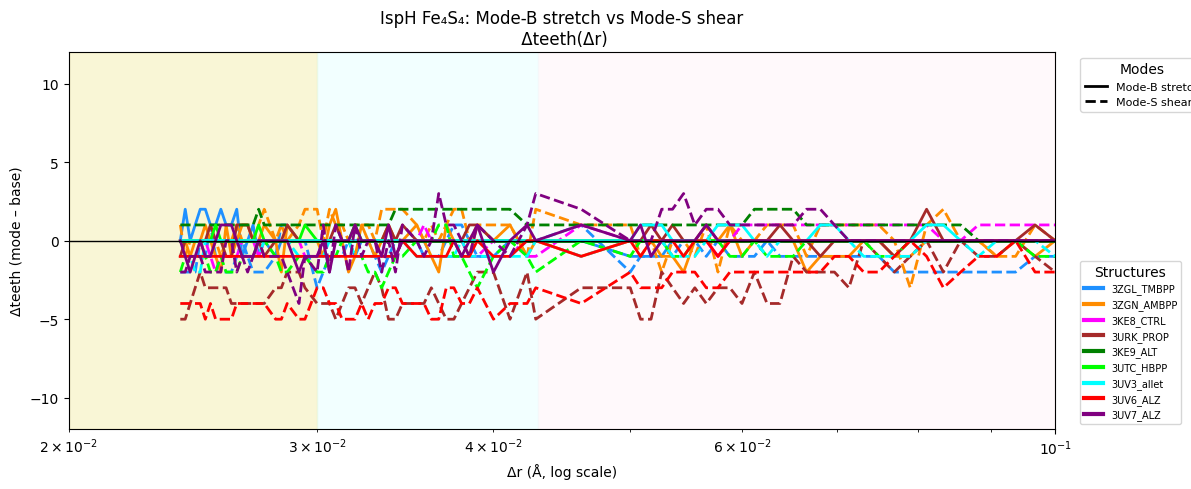

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.lines as mlines

LAP_DIR = Path("/content/")

stretch_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_alt_comb_sto3g.npz"
}

shear_paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_shear_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK_PROP_shear_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9_ALT_shear_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC_HBPP_shear_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_allet_shear_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_ALZ_shear_sto3g.npz",
    "3UV7_ALZ":   LAP_DIR / "3UV7_ALZ_shear_sto3g.npz"
}

BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]

L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":   "purple"
}

def count_traps(mask):
    inside = False
    k = 0
    for m in mask:
        if m and not inside:
            k += 1
            inside = True
        elif not m and inside:
            inside = False
    return k

def dteeth_from_npz(path):
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(kb.min(), km.min())
    kmax = max(kb.max(), km.max())
    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)
        n_b = count_traps(hb < TRAP_THRESHOLD)
        n_m = count_traps(hm < TRAP_THRESHOLD)
        dr_list.append(L_EFF / nb)
        dt_list.append(n_m - n_b)
    return np.array(dr_list), np.array(dt_list)

zone1 = (2e-2, 3e-2)
zone2 = (3e-2, 4.3e-2)
zone3 = (4.3e-2, 1e-1)

fig, ax = plt.subplots(figsize=(12,5))

ax.axvspan(zone1[0], zone1[1], color="khaki", alpha=0.35)
ax.axvspan(zone2[0], zone2[1], color="lightcyan", alpha=0.4)
ax.axvspan(zone3[0], zone3[1], color="lavenderblush", alpha=0.4)

for label in stretch_paths:
    st_path = stretch_paths[label]
    sh_path = shear_paths[label]

    dr_st, dt_st = dteeth_from_npz(st_path)
    dr_sh, dt_sh = dteeth_from_npz(sh_path)

    idx = np.argsort(dr_st)
    dr = dr_st[idx]
    dt_st = dt_st[idx]
    dt_sh = dt_sh[idx]

    mask = (dr >= 2e-2) & (dr <= 1e-1)
    drz = dr[mask]
    stz = dt_st[mask]
    shz = dt_sh[mask]

    c = colors[label]

    ax.plot(drz, stz, "-",  lw=2, color=c)
    ax.plot(drz, shz, "--", lw=2, color=c)

ax.axhline(0, color="black", lw=1)
ax.set_xscale("log")
ax.set_xlim(2e-2, 1e-1)
ax.set_ylim(-12, 12)
ax.set_xlabel("Δr (Å, log scale)")
ax.set_ylabel("Δteeth (mode – base)")
ax.set_title("IspH Fe₄S₄: Mode-B stretch vs Mode-S shear\n Δteeth(Δr)")

stretch_handle = mlines.Line2D([], [], color="black", lw=2, linestyle="-", label="Mode-B stretch")
shear_handle   = mlines.Line2D([], [], color="black", lw=2, linestyle="--", label="Mode-S shear")
mode_legend = ax.legend(handles=[stretch_handle, shear_handle],
                        loc="upper left", bbox_to_anchor=(1.02, 1.0),
                        fontsize=8, title="Modes")

structure_handles = [
    mlines.Line2D([], [], color=colors[label], lw=3, label=label)
    for label in stretch_paths
]
struct_legend = ax.legend(handles=structure_handles,
                          loc="lower left", bbox_to_anchor=(1.02, 0),
                          fontsize=7, title="Structures")

ax.add_artist(mode_legend)

plt.tight_layout()
plt.show()